# Preprocesando imágenes con ImageGenerator

ImageDataGenerator tiene una función llamada flow_from_directory que puede cargar y dividir automáticamente las imágenes en lotes, dependiendo de la estructura de carpetas en la que se encuentren tus imágenes.

Para utilizarlo, debes estructurar tu directorio de imágenes de una manera específica, similar a lo que ya estás haciendo con las carpetas de TRAIN/, VAL/, y TEST/, donde cada una tiene subcarpetas para las clases (por ejemplo, "yes" y "no").

### Pasos para usar ImageDataGenerator con flow_from_directory
1. Estructura del directorio: Debes organizar las imágenes en carpetas, donde cada subcarpeta representa una clase. Ejemplo:
________________________
dataset/

        train/
            yes/
                img1.jpg
                img2.jpg
                ...
            no/
                img1.jpg
                img2.jpg

                ...
        val/
            yes/
                img1.jpg
                ...
            no/

                img1.jpg
                ...
        test/
            yes/
                img1.jpg
                ...
            no/
                img1.jpg
                ...
            

2. Carga y preprocesamiento de imágenes. Utilizas ImageDataGenerator para cargar automáticamente los datos de entrenamiento, validación y test desde esas carpetas. Aquí te muestro un ejemplo:
_____________________________________________________________________________________

```python
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    # Inicializa los generadores de datos para train, val y test
    train_datagen = ImageDataGenerator(rescale=1./255)  # Normaliza los valores de píxeles a [0, 1]
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Carga las imágenes desde las carpetas organizadas
    train_generator = train_datagen.flow_from_directory(
        'dataset/train',         # Directorio de entrenamiento
        target_size=(150, 150),   # Redimensiona las imágenes a 150x150
        batch_size=32,            # Tamaño del batch
        class_mode='binary')      # Usa 'binary' para clasificación binaria (yes/no)

    val_generator = val_datagen.flow_from_directory(
        'dataset/val',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

    test_generator = test_datagen.flow_from_directory(
        'dataset/test',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
```

## Alternativa con validation_split:
También puedes dividir el conjunto de entrenamiento y validación directamente dentro de ImageDataGenerator utilizando la opción validation_split, sin necesidad de crear carpetas separadas para "train" y "val". Pero ojo! esta opción nos da un conjunto de test, que habrá que crearlo igualmente a mano. Lo cuál nos deja´ri aúnicamente con dos set_ el de training, y el de test. Luego, el de training se dividirá con el split en train y validation.

```python
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'dataset',  # Directorio base
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training')  # Define que este es el conjunto de entrenamiento

val_generator = train_datagen.flow_from_directory(
    'dataset',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation')  # Define que este es el conjunto de validación
```

**Dataset de animales**


C:\Users\Administrador.CRISASUSESTUDIO\Desktop\InteligenciaArtificial\dataset\dataset

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Conv2D # la función Conv2D que sirve para crear cada una de las capas de convolución intermedias (ocultas) de las RNC
from keras.layers import MaxPool2D # la función MaxPool2D que sirve para crear cada una de las capas de max-pooling de las RNC
from keras.layers import Flatten # la función Flatten que sirve para crear la capa de flattening de las RNC
from keras.layers import Dense, Dropout


In [20]:
dataset_path = 'C:\\Users\\Administrador.CRISASUSESTUDIO\\Desktop\\InteligenciaArtificial\\dataset_animal'
#C:\Users\Administrador.CRISASUSESTUDIO\Desktop\InteligenciaArtificial\dataset_animal
""""
CONSIDERACIONES: 

-batch_size: un tamaño del lote, preferiblemente no muy grande para evitar colapsar.

-class_mode='binary' para clasificación binaria. 
-Para más de dos clases,  class_mode='categorical'.

-El primer parámetro es el directorio. Para training y val, es el mismo directorio. Para test, la carpeta de test_set.

-subset: ahí ponemos para qué sirve ese lote (training o validation). Test no tiene subset.

-target_size: tamaño de las imágenes. Ahí tenemos que jugar con el tamño de las imágenes.

"""


# Crear un generador para el conjunto de entrenamiento y validación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  
)

# Generador para el conjunto de entrenamiento
train_set = train_datagen.flow_from_directory(
    f'{dataset_path}/training_set/',  
    target_size=(150, 150),  
    batch_size=32,
    class_mode='binary',  
    subset='training'  
)

# Generador para el conjunto de validación
val_set = train_datagen.flow_from_directory(
    f'{dataset_path}/training_set/',  
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  
)

# Generador para el conjunto de test
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(
     f'{dataset_path}/test_set/', 
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False 
)

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


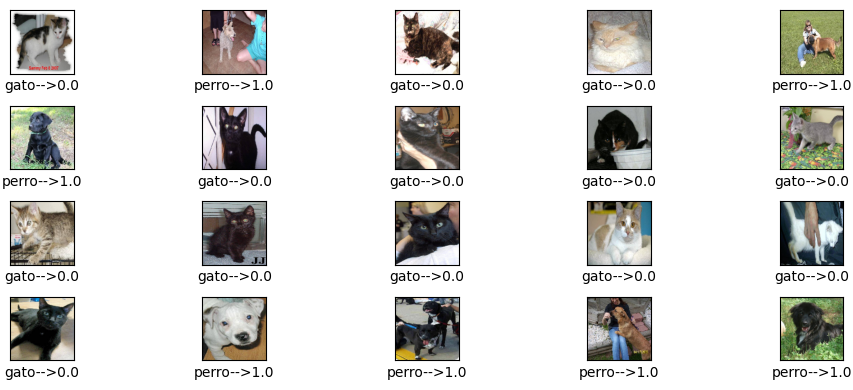

In [42]:
clases= ['gato', 'perro']


# Obtener un lote de imágenes y etiquetas del generador de entrenamiento
images, labels = next(train_set)

plt.figure(figsize=(12,12))
for i in range(20):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(clases[int(labels[i])] + "-->" + str(labels[i]))
    
# Ajustar el espacio entre las subtramas
plt.subplots_adjust(hspace=0.5)
plt.show()

### Construcción de la red neuronal convolucional

En este punto elegiremos entre dos opciones:
1. Construimos nuestra propia red neuronal para clasificar imágenes
2. Cargamos un modelo que ya está pre-entrenado y lo ajustamos a nuestro problema

** Construcción de nuestra red neuronal convolucional **


In [22]:
# Inicializamos la RNC con la función Sequential
rnc = Sequential()
#! eL INPUT_SHAPE debe coincidir con el tamaño de las imágenes que estamos utilizando (target_size)
rnc.add(Conv2D(filters=32, kernel_size=(3, 3),
               input_shape=[150, 150, 3], activation='relu'))
               # Añadimos la primera capa de max pooling utilizando la función MaxPool2D
rnc.add(MaxPool2D(pool_size =(2,2), strides=2))
rnc.add(Conv2D(32, (3, 3), activation='relu'))
rnc.add(MaxPool2D(pool_size=(2, 2)))
rnc.add(Conv2D(64, (3, 3), activation='relu'))
rnc.add(MaxPool2D(pool_size=(2, 2)))
rnc.add(Flatten())
rnc.add(Dense(units = 64, kernel_initializer = "uniform",  activation = "relu"))
rnc.add(Dropout(0.5))
rnc.add(Dense(units = 1, kernel_initializer = "uniform",  activation = "sigmoid"))
rnc.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


** Opción 2: utilizamos el modelo preentrenado de VGG16 u otro modelo preentrenado	**

In [34]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense


# Cargamos el modelo base
base_model = VGG16(
     weights="imagenet",
     include_top=False,
     input_shape=[150, 150, 3]
)


#TODO Ahora que tneemos el modelo VGG16, vamos a añadir nuestras capas densas
x = base_model.output
x = Flatten()(x)  # Aplanamos la salida del modelo base
x = Dense(1, activation='sigmoid')(x)  # Añadimos una capa densa con una activación sigmoide

model = Model(inputs=base_model.input, outputs=x)

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
model.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,722,881 (56.16 MB)

 Trainable params: 14,722,881 (56.16 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamos el modelo

1. train_set.n y val_set.n devuelve el número total de imágenes en el directorio especificado cuando se llamó a flow_from_directory. En tu caso, este sería el número total de imágenes en el conjunto de entrenamiento.
   
2. steps_per_epoch en el método fit es el número de pasos que el generador debe tomar antes de que se considere que se ha completado una época. Un paso implica pasar un lote de imágenes a través del modelo, por lo que steps_per_epoch es normalmente igual al número total de imágenes dividido por el tamaño del lote. Esto asegura que todas las imágenes se pasen a través del modelo exactamente una vez por época.

Durante el entrenamiento, el modelo recibe los datos en pequeños lotes (en tu caso, de tamaño 32). Para cada lote, el modelo hace una predicción, calcula el error comparando la predicción con las etiquetas reales, y luego ajusta sus pesos internos para minimizar ese error. Este proceso se conoce como propagación hacia atrás.

In [38]:
print("Tamaño del set de entrenamiento: ", train_set.n)
print("Tamaño del set de validacion: ", val_set.n)
print("Tamaño del set de test: ", test_set.n)

print("Tamaño del lote de entrenamiento: ", train_set.batch_size)
print("Tamaño del lote de validacion: ", val_set.batch_size)
print("Tamaño del lote de test: ", val_set.batch_size)

Tamaño del set de entrenamiento:  6400
Tamaño del set de validacion:  1600
Tamaño del set de test:  2000
Tamaño del lote de entrenamiento:  32
Tamaño del lote de validacion:  32
Tamaño del lote de test:  32


In [35]:
EPOCHS = 30
es = EarlyStopping(
    monitor='accuracy',
    mode='max',
    patience=6
)

# Número total de imágenes en el conjunto de entrenamiento
num_train_images = train_set.n

# Número total de imágenes en el conjunto de validación
num_val_images = val_set.n

history = model.fit(
    train_set,
    steps_per_epoch=num_train_images // train_set.batch_size,
    epochs=EPOCHS,
    validation_data=val_set,
    validation_steps=num_val_images // val_set.batch_size,
    callbacks=[es]
)

Epoch 1/30


c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  5/200 ━━━━━━━━━━━━━━━━━━━━ 26:32 8s/step - accuracy: 0.5020 - loss: 0.7347

KeyboardInterrupt: 

### Interpretación de los datos

Antes de pasar al punto de realizar las predicciones, vamos a interpretar nuestros datos -concretamente, el accuracy y la función de pérdida.

-Un alto accuracy quiere decir que acierta en un porcentaje alto, y al contrario, un bajo accuracy es que suele fallar.

-Un bajo loss significa que el modelo no está cometiendo muchos errores, mientras que un alto loss indica que el modelo está cometiendo muchos errores.

**Ahora bien, ¿qué significa un alto loss y un alto accuracy? ¿No son contradictorios?**

**Cross-entropy**. Partimos de que estamos usando el Cross-entropy loss, que mide la diferencia entre las probabilidades predichas por el modelo y las etiquetas reales. Es decir, un valor del 0.99 pero que acierta, dará un buen resultado. Pero decir que ha acertado al 99% y equivocarse penalizará mucho el modelo.

Sabiendo esto, un alto loss combinado con un accuracy relativamente alto puede ocurrir si el modelo hace predicciones muy confiadas pero equivocadas. Por ejemplo, en clasificación binaria:

-Si el modelo predice una clase con una probabilidad muy alta (como 99%) pero está equivocada, el loss será muy alto.

-Sin embargo, en otras muestras puede estar acertando muchas veces, lo que eleva el accuracy al 75%.

Este comportamiento ocurre con mayor frecuencia cuando usas cross-entropy loss, que penaliza fuertemente las predicciones muy incorrectas. Un loss alto con un accuracy decente también puede ser un síntoma de overfitting, donde el modelo memoriza los datos de entrenamiento en lugar de aprender patrones generales.


**Problemas de sesgo**

Otra posibilidad es que tu modelo tenga un sesgo hacia una clase en particular.

Si tu modelo tiene un sesgo muy alto hacia una clase y predice casi siempre la misma clase, eso podría explicar por qué tienes un accuracy relativamente alto y un loss elevado. Este fenómeno es común en problemas de clases desequilibradas o cuando el modelo ha desarrollado un sesgo durante el entrenamiento.

### Realizamos las predicciones con el conjunto de test

In [ ]:
# Realizar predicciones en el conjunto de prueba
predictions = model.predict(test_set)

# Las predicciones serán en forma de probabilidades, por lo que puedes querer convertirlas a etiquetas de clase
# Esto se puede hacer tomando el índice de la probabilidad más alta
predicted_classes = np.argmax(predictions, axis=1)

### Comprobamos qué tan certeras eran las predicciones

In [ ]:
# Obtener las etiquetas reales del conjunto de prueba
real_labels = test_set.classes

# Obtener la predicción para la primera imagen
predicted_label = predicted_classes[0]

# Obtener la etiqueta real para la primera imagen
real_label = real_labels[0]

print(f"Predicción: {clases[predicted_label]}")
print(f"Etiqueta real: {clases[real_label]}")